In [2]:
# Dependencies:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
from config import api_key
from pprint import pprint
import requests
import math
import seaborn as sns
import cytoolz
import gmaps
from api_keys import gmaps_key


In [2]:
# Data 
# global netflix data from netflix.com top 10 weekly shows
global_netflix_df = pd.read_csv("Resources/all-weeks-global.csv")
global_netflix_df.head()
global_netflix_df.dtypes

# Netflix Title data from kaggle.com- has title, info, imdb ratings, etc.
titles_netflix_df = pd.read_csv("Resources/titles.csv")
titles_netflix_df.head()
titles_netflix_df.dtypes

# Merge 
global_titles_df = pd.merge(global_netflix_df, titles_netflix_df, how= "left", left_on="show_title", right_on="title")
global_titles_df.drop(["title","tmdb_popularity","tmdb_score"], axis=1, inplace=True)
global_titles_df

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,cumulative_weeks_in_top_10,id,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes
0,2022-10-30,Films (English),1,The Good Nurse,NaN,68310000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-30,Films (English),2,The School for Good and Evil,NaN,41950000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-30,Films (English),3,The Stranger,NaN,9170000,2,ts224901,SHOW,A web of secrets sends family man Adam Price o...,2020.0,TV-MA,45.0,"['thriller', 'crime', 'drama']",['GB'],1.0,tt9698480,7.3,48298.0
3,2022-10-30,Films (English),4,Wild Is the Wind,NaN,8890000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-30,Films (English),5,The Curse of Bridge Hollow,NaN,8170000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,2021-07-04,TV (Non-English),6,Elite,Elite: Season 1,10530000,1,ts78305,SHOW,When three working class kids enroll in the mo...,2018.0,TV-MA,48.0,"['thriller', 'drama', 'crime']",['ES'],5.0,tt7134908,7.4,75337.0
2816,2021-07-04,TV (Non-English),7,Elite,Elite: Season 3,10200000,1,ts78305,SHOW,When three working class kids enroll in the mo...,2018.0,TV-MA,48.0,"['thriller', 'drama', 'crime']",['ES'],5.0,tt7134908,7.4,75337.0
2817,2021-07-04,TV (Non-English),8,Elite,Elite: Season 2,10140000,1,ts78305,SHOW,When three working class kids enroll in the mo...,2018.0,TV-MA,48.0,"['thriller', 'drama', 'crime']",['ES'],5.0,tt7134908,7.4,75337.0
2818,2021-07-04,TV (Non-English),9,Katla,Katla: Season 1,9190000,1,ts237972,SHOW,"A year after a subglacial volcano erupts, myst...",2021.0,TV-MA,46.0,"['drama', 'thriller', 'scifi']",['IS'],1.0,tt11102190,7.0,13472.0


In [206]:
url = "http://www.omdbapi.com/?t="
api_key = f"&apikey={api_key}"

In [ ]:
# Changing all NAN values to NA in global_titles_df for easy referencing 
df = global_titles_df.fillna("NA")
df
# filtering data where imdb_score is NA and respective show title
df1 = df.loc[df["imdb_score"]=="NA","show_title"]
# Created the movie list with unique movie/show names
movies_list = df1.unique().tolist()
# Total number of unique movies/shows
len(movies_list)

In [ ]:
# List that has unique movie/show names
movies_list
# Empty list to store fetched data from API
data = []
# API Key
api_key = f"&apikey={api_key}"
# looping through the movie list and fetching data for each movie
for movie in movies_list:
    try:
        response = requests.get(url+movie+api_key).json()
        # Appending data to the list
        data.append({"show_title":response["Title"],
                    "id" :response["imdbID"],"type":response["Type"],"description":response["Plot"],
                    "release_year":response["Year"],"age_certification":response["Rated"],"runtime":response["Runtime"],
                    "genres":response["Genre"],"production_countries":response["Country"],"imdb_id":response["imdbID"],
                    "imdb_score":response["imdbRating"],"imdb_votes":response["imdbVotes"]})
    except KeyError:
        pass

In [ ]:
# Converting the data fetched from API in to the dataframe
df3 = pd.DataFrame(data)
df3
# Exporting data fetched from the API to csv file
df3.to_csv("output_data/api_data.csv")

In [ ]:
# merged the data fetched from API DF(df3) with the dataframe we hav(global_titles_df)
#changing all show titles into lower case 
global_titles_df["Show_title"]=global_titles_df['show_title'].str.lower()
df3["Show_title"]=df3['show_title'].str.lower()
merge_df = pd.merge(global_titles_df, df3, how= "left",on="Show_title")
# combining the data and storing it in separate column.(eg:combined type_x,type_y into one column type) and data cleaning
combined_df = merge_df.assign(type=merge_df.type_x.fillna(merge_df.type_y))
combined_df = combined_df.assign(description=merge_df.description_x.fillna(merge_df.description_y))
combined_df = combined_df.assign(release_year=merge_df.release_year_x.fillna(merge_df.release_year_y))
combined_df = combined_df.assign(age_certification=merge_df.age_certification_x.fillna(merge_df.age_certification_y))
combined_df = combined_df.assign(runtime=merge_df.runtime_x.fillna(merge_df.runtime_y))
combined_df = combined_df.assign(genres=merge_df.genres_x.fillna(merge_df.genres_y))
combined_df = combined_df.assign(production_countries=merge_df.production_countries_x.fillna(merge_df.production_countries_y))
combined_df = combined_df.assign(imdb_id=merge_df.imdb_id_x.fillna(merge_df.imdb_id_y))
combined_df = combined_df.assign(imdb_score=merge_df.imdb_score_x.fillna(merge_df.imdb_score_y))
combined_df = combined_df.assign(imdb_votes=merge_df.imdb_votes_x.fillna(merge_df.imdb_votes_y))
#dropping used columns
combined_df.drop(["show_title_x","show_title_y","id_x","id_y","type_x","type_y","description_x","description_y","release_year_x",
                "release_year_y","age_certification_x","age_certification_y","runtime_x","runtime_y","genres_x","genres_y",
                "production_countries_x","production_countries_y","imdb_id_x","imdb_id_y","imdb_score_x","imdb_score_y",
                "imdb_votes_x","imdb_votes_y","season_title","seasons"], axis=1, inplace=True)
#dropped all rows that has NAN values 
combined_df = combined_df.dropna()
# Dropped all rows that has imdb_score equal to N/A
cleaned_df = combined_df.loc[combined_df["imdb_score"]!="N/A"]
cleaned_df = combined_df.loc[combined_df["runtime"]!="N/A"]
cleaned_df = combined_df.loc[combined_df["age_certification"]!="N/A"]
#saving the dataframe into csv file
cleaned_df.to_csv("output_data/cleaned_netflix_data.csv")
print(cleaned_df.count())
cleaned_df

In [3]:
netflix_df = pd.read_csv("output_data/cleaned_netflix_data.csv")
netflix_df.head()
list = netflix_df["Show_title"].unique()
len(list)


644

In [6]:
# Grouped by show_title to find top weekly rank per each movie vs cumulative_weeks_in_top_10
groupedby_title = netflix_df.groupby("Show_title").agg({"weekly_rank":"min","cumulative_weeks_in_top_10":"max"}).reset_index()

rank_df = pd.merge(groupedby_title,netflix_df,how="inner",on=["Show_title","weekly_rank","cumulative_weeks_in_top_10"])
rank_df


,Show_title,weekly_rank,cumulative_weeks_in_top_10,week,category,weekly_hours_viewed,type,description,release_year,age_certification,...,production_countries,imdb_id,imdb_score,imdb_votes,drama,comedy,action,family,crime,romance
0,1917,7,1,2022-08-14,Films (English),10840000,movie,"April 6th, 1917. As an infantry battalion asse...",2019,R,...,"United Kingdom, United States, India, Spain",tt8579674,8.2,579698.0,1,0,1,0,0,0
1,21 jump street,6,1,2021-11-07,Films (English),11690000,movie,A pair of underachieving cops are sent back to...,2012,R,...,United States,tt1232829,7.2,556200.0,0,1,1,0,1,0
2,211,6,1,2021-11-14,Films (English),7900000,movie,"While on a routine patrol, an aging cop, his p...",2018,R,...,"United States, Bulgaria",tt4976192,4.4,8489.0,1,0,1,0,0,0
3,42 days of darkness,7,1,2022-05-15,TV (Non-English),9920000,SHOW,"In a town in Chile, a woman leads a frantic se...",2022,TV-MA,...,Chile,tt15090462,6.5,1040.0,1,0,0,0,1,0
4,6 underground,5,3,2022-04-03,Films (English),8730000,MOVIE,"After faking his death, a tech billionaire rec...",2019,R,...,United States,tt8106534,6.1,172083.0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,world trade center,10,1,2021-08-08,Films (English),5050000,movie,Two Port Authority police officers become trap...,2006,PG-13,...,"Germany, United States",tt0469641,6.0,84290.0,1,0,0,0,0,0
308,worth,3,2,2021-09-12,Films (English),13560000,MOVIE,"Kenneth Feinberg, a powerful D.C. lawyer appoi...",2021,PG-13,...,"Canada, United Kingdom, United States",tt8009744,6.8,13524.0,1,0,0,0,0,0
309,yakuza princess,5,1,2022-04-24,Films (English),7490000,movie,The heiress to half of the Yakuza crime syndic...,2021,R,...,Brazil,tt10715446,4.7,1708.0,0,0,0,0,0,0
310,yeh kaali kaali ankhein,6,1,2022-01-23,TV (Non-English),11260000,SHOW,Relentlessly pursued by a powerful politician’...,2022,TV-MA,...,India,tt14160712,7.0,7569.0,1,0,0,0,1,0


In [38]:
weekly_rank = rank_df.iloc[:,1]
cumulative_weeks_in_top_10 = rank_df.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")

correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.38


In [46]:
#Films (English)
films_english = rank_df.loc[rank_df["category"]=="Films (English)"]
weekly_rank = films_english.iloc[:,1]
cumulative_weeks_in_top_10 = films_english.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")


correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.33


In [44]:
#TV_Non_English
TV_Non_English = rank_df.loc[rank_df["category"]=="TV (Non-English)"]
weekly_rank = TV_Non_English.iloc[:,1]
cumulative_weeks_in_top_10 = TV_Non_English.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")


correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.66


In [45]:
#TV_English
TV_English = rank_df.loc[rank_df["category"]=="TV (English)"]
weekly_rank = TV_English.iloc[:,1]
cumulative_weeks_in_top_10 = TV_English.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")


correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.22


In [49]:
# Films_Non_English
Films_Non_English = rank_df.loc[rank_df["category"]=="Films (Non-English)"]
weekly_rank = Films_Non_English.iloc[:,1]
cumulative_weeks_in_top_10 = Films_Non_English.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")
#Films_Non_English

correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.39


In [59]:
#Films_Non_English
Films_Non_English = rank_df.loc[rank_df["category"]=="Films (Non-English)"]
corr_matrix = Films_Non_English.corr()
# Largest positive corr:
print(corr_matrix.unstack().sort_values().tail(35))
# Largest negative corr:
print(corr_matrix.unstack().sort_values().head(22))

drama                       imdb_score                    0.209514
imdb_score                  drama                         0.209514
imdb_votes                  drama                         0.215612
drama                       imdb_votes                    0.215612
weekly_hours_viewed         imdb_score                    0.217333
imdb_score                  weekly_hours_viewed           0.217333
comedy                      romance                       0.230949
romance                     comedy                        0.230949
runtime (mins)              action                        0.248337
action                      runtime (mins)                0.248337
family                      cumulative_weeks_in_top_10    0.256782
cumulative_weeks_in_top_10  family                        0.256782
runtime (mins)              weekly_hours_viewed           0.266671
weekly_hours_viewed         runtime (mins)                0.266671
cumulative_weeks_in_top_10  comedy                        0.29

In [60]:
#Films_English
Films_English = rank_df.loc[rank_df["category"]=="Films (English)"]
corr_matrix = Films_English.corr()

print(corr_matrix.unstack().sort_values().tail(35))
# Largest negative corr:
print(corr_matrix.unstack().sort_values().head(22))

comedy                      family                        0.139393
family                      comedy                        0.139393
cumulative_weeks_in_top_10  release_year                  0.160976
release_year                cumulative_weeks_in_top_10    0.160976
cumulative_weeks_in_top_10  weekly_hours_viewed           0.182535
weekly_hours_viewed         cumulative_weeks_in_top_10    0.182535
imdb_votes                  weekly_rank                   0.202922
weekly_rank                 imdb_votes                    0.202922
release_year                weekly_hours_viewed           0.209689
weekly_hours_viewed         release_year                  0.209689
imdb_votes                  runtime (mins)                0.225593
runtime (mins)              imdb_votes                    0.225593
comedy                      cumulative_weeks_in_top_10    0.246518
cumulative_weeks_in_top_10  comedy                        0.246518
comedy                      romance                       0.27

In [61]:
#TV (Non-English)
Films_English = rank_df.loc[rank_df["category"]=="TV (Non-English)"]
corr_matrix = Films_English.corr()

print(corr_matrix.unstack().sort_values().tail(35))
# Largest negative corr:
print(corr_matrix.unstack().sort_values().head(22))

drama                       imdb_score                    0.208178
imdb_score                  drama                         0.208178
imdb_votes                  weekly_rank                   0.210537
weekly_rank                 imdb_votes                    0.210537
weekly_hours_viewed         release_year                  0.214922
release_year                weekly_hours_viewed           0.214922
comedy                      imdb_votes                    0.227763
imdb_votes                  comedy                        0.227763
comedy                      imdb_score                    0.249565
imdb_score                  comedy                        0.249565
comedy                      action                        0.269320
action                      comedy                        0.269320
comedy                      romance                       0.274480
romance                     comedy                        0.274480
imdb_score                  runtime (mins)                0.29

In [7]:
# titles showed up in cumulative_weeks_in_top_10 for more than 10 times
weeks_in_top10 = netflix_df.groupby("Show_title").max().sort_values(by="cumulative_weeks_in_top_10",ascending=False).reset_index()

weeks_in_top10 = weeks_in_top10.loc[weeks_in_top10["cumulative_weeks_in_top_10"]>=10][["Show_title","category","cumulative_weeks_in_top_10","type","production_countries"]]

weeks_in_top10

,Show_title,category,cumulative_weeks_in_top_10,type,production_countries
0,"yo soy betty, la fea",TV (Non-English),30,series,Colombia
1,squid game,TV (Non-English),20,SHOW,South Korea
2,stranger things,TV (English),19,SHOW,United States
3,manifest,TV (English),19,SHOW,United States
4,extraordinary attorney woo,TV (Non-English),17,SHOW,South Korea
5,hometown cha-cha-cha,TV (Non-English),16,SHOW,South Korea
6,the queen of flow,TV (Non-English),16,SHOW,Columbia
7,alchemy of souls,TV (Non-English),15,SHOW,South Korea
8,money heist,TV (Non-English),14,SHOW,Spain
9,red notice,Films (English),14,MOVIE,United States


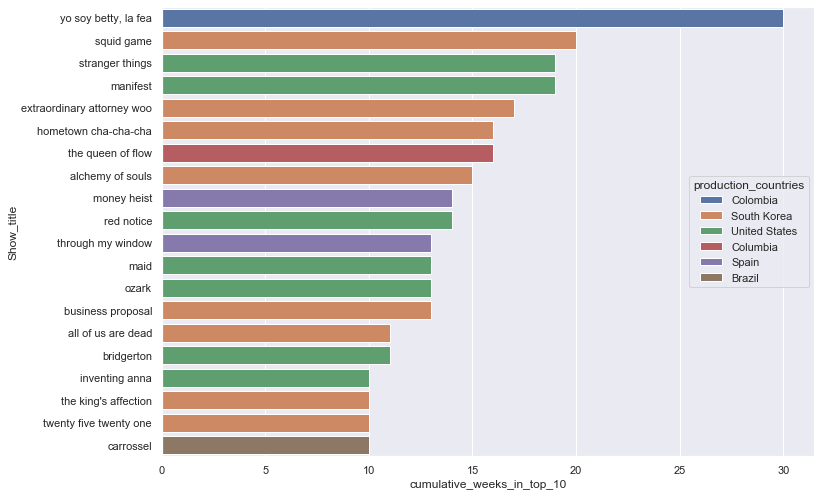

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(data=weeks_in_top10, y= "Show_title", x ="cumulative_weeks_in_top_10",hue="production_countries",dodge=False)
sns.move_legend(plot, "center right")

In [73]:
# Netflix hits don't stay popular for long
weeks_in_top10 = netflix_df.groupby("Show_title").max().sort_values(by="cumulative_weeks_in_top_10",ascending=False).reset_index()
popularity_fading = weeks_in_top10.groupby("cumulative_weeks_in_top_10").count().sort_values(by="cumulative_weeks_in_top_10").reset_index()
popularity_fading = popularity_fading[["Show_title","cumulative_weeks_in_top_10"]]
popularity_fading

,Show_title,cumulative_weeks_in_top_10
0,237,1
1,168,2
2,97,3
3,42,4
4,35,5
5,22,6
6,10,7
7,11,8
8,2,9
9,4,10


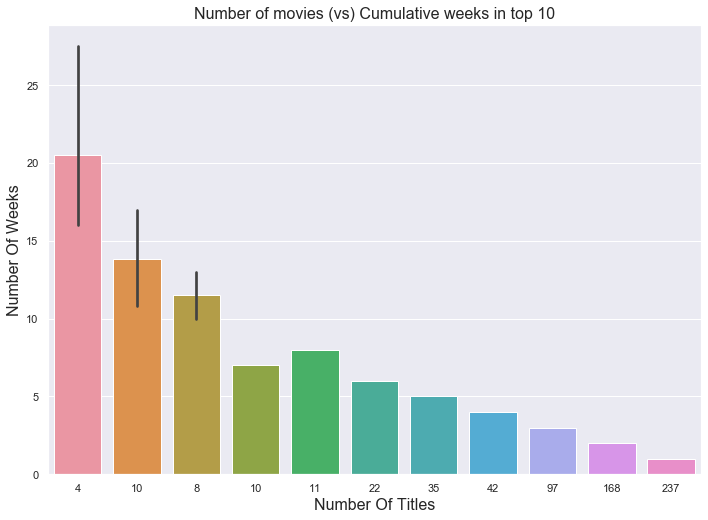

In [74]:
# Netflix hits don't stay popular for long

popularity_fading = weeks_in_top10.groupby("cumulative_weeks_in_top_10").count().sort_values(by="cumulative_weeks_in_top_10").reset_index()
popularity_fading = popularity_fading[["Show_title","cumulative_weeks_in_top_10"]]
# avg_weeks = popularity_fading.groupby("Show_title").mean().reset_index()
# avg_weeks
# Bar graph to show how many movies stayed in top for long
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax= sns.barplot(data=popularity_fading, y= "cumulative_weeks_in_top_10", x ="Show_title")
ax.set_xticklabels([4,10,8,10,11,22,35,42,97,168,237])
#ax.set(xlabel='Number Of Titles', ylabel='Average Number Of Weeks',title="Number of movies (vs) Cumulative weeks in top 10")
plt.xlabel('Number Of Titles', fontsize=16)
plt.ylabel("Number Of Weeks",fontsize=16)
plt.title("Number of movies (vs) Cumulative weeks in top 10",fontsize=16)
plt.show()



**Netflix hits don't stay popular for long**
- As the chart shows only handful of movies stays in top 10 for more than 10 cumulative weeks.
- The popularity of the content fades as the weeks pass.
- Less than 1% of content stays top more than 20 weeks and about 2% of contents stays top more than 10 cumulativeweeks.
- About 90% of the content won't stay in top more than 3 cumulative weeks

In [12]:
# Analysis to show each country contribution
country_tv_count = netflix_df.loc[netflix_df["category"]=="TV (Non-English)"].groupby("production_countries").count().reset_index()[["production_countries","Show_title"]]
country_tv_count
country_movie_count = netflix_df.loc[netflix_df["category"]=="Films (Non-English)"].groupby("production_countries").count().reset_index()[["production_countries","Show_title"]]
country_movie_count
#merge_df = pd.merge(global_titles_df, df3, how= "left",on="Show_title")
production = pd.merge(country_tv_count,country_movie_count, how="outer",on="production_countries")
production.rename(columns = {'Show_title_x':'Tv', 'Show_title_y':'Films'}, inplace = True)
print(production.columns)
production.set_axis(["production_countries",'Tv', 'Films'], axis='columns', inplace=True)
production.head()

Index(['production_countries', 'Tv', 'Films'], dtype='object')


,production_countries,Tv,Films
0,Argentina,3.0,2.0
1,Australia,1.0,NaN
2,"Austria, Germany",1.0,NaN
3,Belgium,4.0,NaN
4,Brazil,33.0,5.0


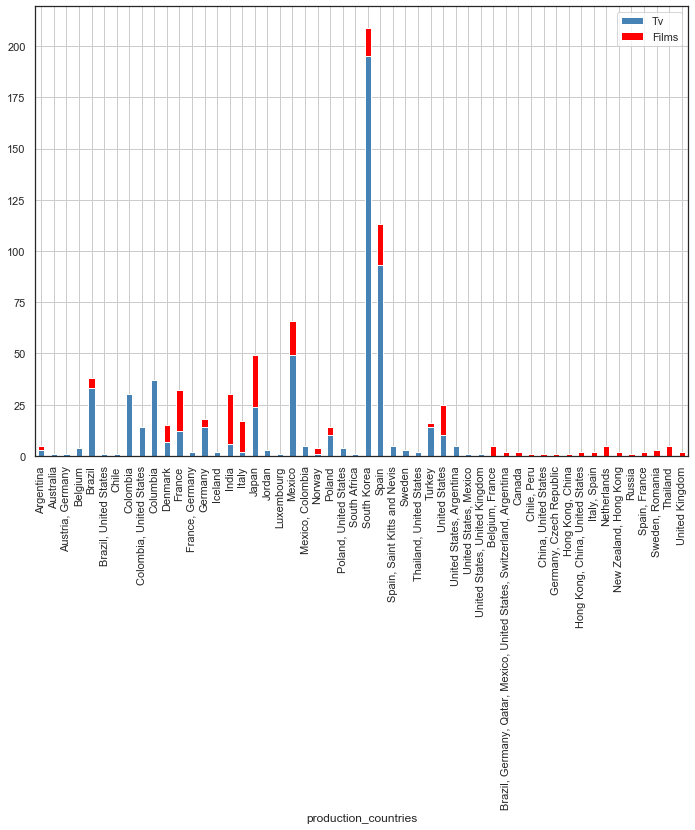

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
production.set_index('production_countries').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
plt.grid()

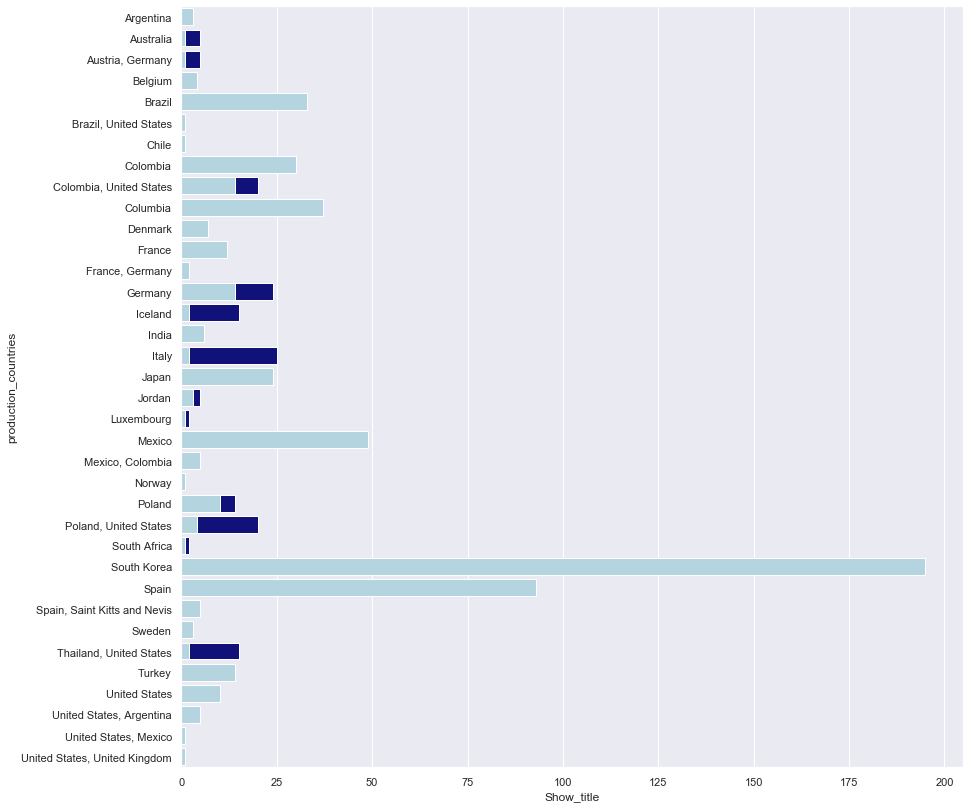

In [50]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(14, 14))

bar1 = sns.barplot(x=country_movie_count["Show_title"],  y=country_movie_count["production_countries"], data=country_movie_count, color='darkblue')
bar2 = sns.barplot(x=country_tv_count["Show_title"], y=country_tv_count["production_countries"], data=country_tv_count, estimator=sum, ci=None,  color='lightblue')

In [76]:
# Top 10 and least 10 genre combinations according to average IMDB score which has votes more than 1000
genre_score = netflix_df.loc[(netflix_df["imdb_votes"]>=1000 )& (netflix_df["imdb_score"] ),["genres","imdb_score"]]
genre_score = genre_score.groupby("genres").mean().reset_index().sort_values(by="imdb_score",ascending=False)
top_10 = genre_score.loc[genre_score["imdb_score"]>8].head(10)
least_10 = genre_score.loc[genre_score["imdb_score"]<5].tail(10)
top_10
least_10

,genres,imdb_score
210,"horror, thriller, crime",4.800000
56,"animation, adventure, family",4.800000
12,"action, comedy, drama",4.733333
29,"action, fantasy",4.700000
226,"scifi, action",4.700000
46,"adventure, drama, fantasy",4.700000
262,"thriller, action, drama",4.500000
197,"fantasy, action, crime, drama",4.400000
96,"crime, action, drama, thriller",3.800000
249,"scifi, thriller, action, horror",3.700000


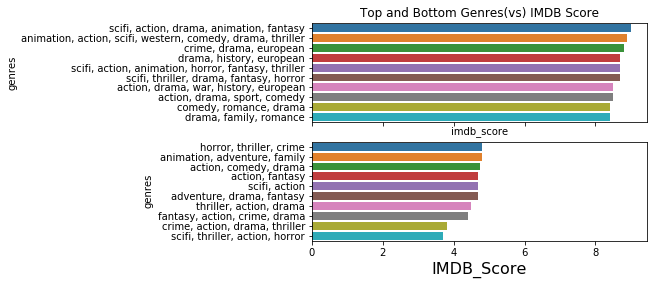

In [51]:
# Plot to show top movies or shows according to genres based on IMDB Score
#define plotting region (2 rows, 1 columns)
fig, ax = plt.subplots(2, 1,sharex=True)
ax1 = sns.barplot(data=top_10, x= "imdb_score", y ="genres",ax=ax[0]).set( Title="Top and Bottom Genres(vs) IMDB Score")
ax2 = sns.barplot(data=least_10, x= "imdb_score", y ="genres",ax=ax[1])
plt.xlabel('IMDB_Score', fontsize=16)
plt.show()


**How Different Combination of genres working?**
- Analysis was made on those movie/shows that has more than 1000 votes because these ratings are from worldwide. Grouped by movies that has these genre combinations and calculated the average rating for each combo of the genre.
- This chart depicts how various combinations of genres effect IMDB Score and also the top 10 genre combinations and bottom ten genre combinations. 
- The shows/movies that has combination scifi,action,drama,animation,fantasy has average rating of 9 which is in top. 
- The shows/movies that has combination of scifi, thriller, action, horror has average rating of 3.7 which is in bottom.


In [22]:
netflix_df.head()

,week,category,weekly_rank,weekly_hours_viewed,cumulative_weeks_in_top_10,Show_title,type,description,release_year,age_certification,...,production_countries,imdb_id,imdb_score,imdb_votes,drama,comedy,action,family,crime,romance
0,2022-10-30,Films (English),1,68310000,1,the good nurse,movie,An infamous caregiver is implicated in the dea...,2022,R,...,United States,tt4273800,7.1,204.0,1,0,0,0,1,0
1,2022-10-30,Films (English),2,41950000,2,the school for good and evil,movie,Best friends Sophie and Agatha find themselves...,2022,PG-13,...,United States,tt2935622,5.8,18952.0,1,1,1,0,0,0
2,2022-10-30,Films (English),3,9170000,2,the stranger,SHOW,A web of secrets sends family man Adam Price o...,2020,TV-MA,...,United Kingdom,tt9698480,7.3,48298.0,1,0,0,0,1,0
3,2022-10-30,Films (English),4,8890000,1,wild is the wind,movie,An immigrant Nevada rancher brings a woman fro...,1957,Not Rated,...,United States,tt0051193,6.7,1027.0,1,0,0,0,0,0
4,2022-10-30,Films (English),5,8170000,3,the curse of bridge hollow,movie,"A teenage girl, who accidentally releases an a...",2022,TV-14,...,United States,tt15289240,NaN,4085.0,0,1,0,1,0,0


In [4]:
country = netflix_df.groupby("Show_title").max().sort_values(by="cumulative_weeks_in_top_10",ascending=False).reset_index()
total = country[["production_countries"]]

# Converting production_countries column into list to show total number of movies each country produced
c2 = np.core.defchararray.split(total.production_countries.values.astype('str'), ',')
col2 = list(cytoolz.concat(c2))
# Converting list to DataFrame
df=pd.DataFrame(col2,columns=["Country"])
series_values = df["Country"].value_counts()

country_stats = pd.DataFrame(series_values,columns=["Country"]).reset_index()
country_stats = country_stats.rename(columns={"index":"country","Country":"movies_Produced"})
country_stats = country_stats.groupby("country").sum().sort_values(by="movies_Produced",ascending=False)
country_stats = country_stats.reset_index()
country_stats.head(10)


TypeError: 'numpy.ndarray' object is not callable

In [82]:
country = netflix_df.groupby("Show_title").max().sort_values(by="cumulative_weeks_in_top_10",ascending=False).reset_index()
total = country[["production_countries"]]

# Converting production_countries column into list to show total number of movies each country produced
c2 = np.core.defchararray.split(total.production_countries.values.astype('str'), ',')
col2 = list(cytoolz.concat(c2))
# Converting list to DataFrame
df=pd.DataFrame(col2,columns=["Country"])
series_values = df["Country"].value_counts()

country_stats = pd.DataFrame(series_values,columns=["Country"]).reset_index()
country_stats = country_stats.rename(columns={"index":"country","Country":"movies_Produced"})
country_stats = country_stats.groupby("country").sum().sort_values(by="movies_Produced",ascending=False)
country_stats = country_stats.reset_index()
country_stats.head(10)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# # Configure the map plot
# gmaps.configure(api_key=gmaps_key)
# # YOUR CODE HERE
# locations = country_stats[["Lat", "Lng"]].astype(float)
# humidity = city_data_df["Humidity"].tolist()
# scale1=[]
# for hum in humidity:
#     scale = hum/10
#     ceil_value = math.ceil(scale)
#     scale1.append(ceil_value)


# humidity_layer = gmaps.symbol_layer(locations, fill_color="red",stroke_color='rgba(0, 0, 150, 0.4)', fill_opacity =1,
#      scale=scale1,info_box_content=[f"humidity amount: {hum}" for hum in humidity])
# fig = gmaps.figure()
# fig.add_layer(humidity_layer)
# fig